In [1]:
# Add the relevant scripts from LArMachineLearningData
# Nice the process so it can run with lots of cores on low priority
import os
os.nice(20)

# Add local paths
import sys
hnlDIR = os.environ['_']
sys.path.append('../pyscript')

# From pyscript Library
from Plotting import *
from Dictionary import *
from HelperFunctions import *
from CutFunctions import *

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

<h1>Configuration Stuff Here</h1>

In [2]:
ifTune = False
ifSave = False
savePath = "../plot_files/06Feb24/"

In [3]:
ifStrict = True

In [4]:
TuneCut = {}

if ifStrict:   
    TuneCut = {
    'crumbs': 0.04
    , 'Opt0Score': 1000
    ,'Opt0FracMore': -0.02
    , 'Opt0FracLess': 0.92
    , 'Muon' : 0.02
    , 'Proton' : 0.02
    , 'Pion' : 0.02
    , 'ShowerTheta': 9.2
    }
    
else:
    TuneCut = {
    'crumbs': 0.04
    , 'Opt0Score': 1000
    , 'Opt0FracMore': -0.08
    , 'Opt0FracLess': 0.92
    , 'Muon' : 0.06
    , 'Proton' : 1
    , 'Pion' : 0.98
    , 'ShowerTheta': 12.8
    }
    

<h1> Read in PKL Dataframe </h1>

<h3> HNL </h3>

In [5]:
df_hnl = pd.DataFrame()

for i in range(0, 2):
    hnl_path = "../pkl_files/v1/hnl_m200_50k__slc_{}.pkl".format(i)
    print(hnl_path)
    
    file = open(hnl_path, 'rb')
    df = pickle.load(file)
    
    df_hnl = pd.concat((df_hnl, df), ignore_index=True)
    file.close()
    
#--------------------------------------------------#
dfsubrun_hnl = pd.DataFrame()

for i in range(0, 2):
    hnl_path = "../pkl_files/v1/hnl_m200_50k__subrun_{}.pkl".format(i)
    print(hnl_path)
    
    file = open(hnl_path, 'rb')
    df = pickle.load(file)
    
    dfsubrun_hnl = pd.concat((dfsubrun_hnl, df), ignore_index=True)
    file.close()

../pkl_files/v1/hnl_m200_50k__slc_0.pkl
../pkl_files/v1/hnl_m200_50k__slc_1.pkl
../pkl_files/v1/hnl_m200_50k__subrun_0.pkl
../pkl_files/v1/hnl_m200_50k__subrun_1.pkl


<h3> TPC Neutrino </h3>

In [6]:
df_nu = pd.DataFrame()

for i in range(0, 4):
    nu_path = "../pkl_files/v1/nu_tpc_100k_slc_{}.pkl".format(i)
    print(nu_path)
    
    file = open(nu_path, 'rb')
    df = pickle.load(file)
    
    df_nu = pd.concat((df_nu, df), ignore_index=True)
    file.close()
    
#--------------------------------------------------#
dfsubrun_nu = pd.DataFrame()

for i in range(0, 4):
    nu_path = "../pkl_files/v1/nu_tpc_100k_subrun_{}.pkl".format(i)
    print(nu_path)
    
    file = open(nu_path, 'rb')
    df = pickle.load(file)
    
    dfsubrun_nu = pd.concat((dfsubrun_nu, df), ignore_index=True)
    file.close()

../pkl_files/v1/nu_tpc_100k_slc_0.pkl
../pkl_files/v1/nu_tpc_100k_slc_1.pkl
../pkl_files/v1/nu_tpc_100k_slc_2.pkl
../pkl_files/v1/nu_tpc_100k_slc_3.pkl
../pkl_files/v1/nu_tpc_100k_subrun_0.pkl
../pkl_files/v1/nu_tpc_100k_subrun_1.pkl
../pkl_files/v1/nu_tpc_100k_subrun_2.pkl
../pkl_files/v1/nu_tpc_100k_subrun_3.pkl


<h3> Intime Cosmics </h3>

In [7]:
df_cos = pd.DataFrame()

for i in range(0, 2):
    cos_path = "../pkl_files/v1/cos_50k_slc_{}.pkl".format(i)
    print(cos_path)
    
    file = open(cos_path, 'rb')
    df = pickle.load(file)
    
    df_cos = pd.concat((df_cos, df), ignore_index=True)
    file.close()
    
#--------------------------------------------------#
dfsubrun_cos = pd.DataFrame()

for i in range(0, 2):
    cos_path = "../pkl_files/v1/cos_50k_subrun_{}.pkl".format(i)
    print(cos_path)
    
    file = open(cos_path, 'rb')
    df = pickle.load(file)
    
    dfsubrun_cos = pd.concat((dfsubrun_cos, df), ignore_index=True)
    file.close()

../pkl_files/v1/cos_50k_slc_0.pkl
../pkl_files/v1/cos_50k_slc_1.pkl
../pkl_files/v1/cos_50k_subrun_0.pkl
../pkl_files/v1/cos_50k_subrun_1.pkl


In [8]:
df_nu.columns

Index(['run', 'subrun', 'event', 'slc_vtx_x', 'slc_vtx_y', 'slc_vtx_z',
       'slc_is_fv', 'slc_crumbs_score', 'slc_opt0_score', 'slc_opt0_frac',
       'slc_opt0_time_corrected_Z_pandora', 'slc_total_shower_E',
       'slc_total_track_E', 'slc_n_razzled_electrons', 'slc_n_razzled_muons',
       'slc_n_razzled_photons', 'slc_n_razzled_pions_thresh',
       'slc_n_razzled_protons_thresh', 'slc_comp', 'slc_true_event_type',
       'slc_idx', 'slc_pfp_n_hits', 'slc_pfp_track_score',
       'slc_pfp_razzled_electron_score', 'slc_pfp_razzled_muon_score',
       'slc_pfp_razzled_photon_score', 'slc_pfp_razzled_pion_score',
       'slc_pfp_razzled_proton_score', 'slc_pfp_track_end_x',
       'slc_pfp_track_end_y', 'slc_pfp_track_end_z', 'slc_pfp_track_dir_x',
       'slc_pfp_track_dir_y', 'slc_pfp_track_dir_z', 'slc_pfp_track_length',
       'slc_pfp_track_ke', 'slc_pfp_track_theta', 'slc_pfp_track_phi',
       'slc_pfp_shower_end_x', 'slc_pfp_shower_end_y', 'slc_pfp_shower_end_z',
       's

<h1> Split in to 1 shower/2 showers case </h1>

In [9]:
def split_my_df(df):
    temp = df[['run', 'subrun', 'event', 'slc_idx', 'slc_comp', 'slc_true_event_type'
               , 'slc_pfp_track_score', 'slc_pfp_shower_theta', 'slc_pfp_shower_phi'
                ,'slc_pfp_shower_energy' ,'slc_pfp_track_ke' , 'slc_opt0_frac', 'slc_opt0_score'
                  ]]
    temp["pfp_idx"] = temp.groupby(['run', 'subrun', 'event', 'slc_idx']).transform("cumcount").add(1) - 1
    temp = temp.set_index(['run', 'subrun', 'event', 'slc_idx']).reset_index()
    
    temp1 = temp.groupby(['run', 'subrun', 'event', 'slc_idx'])['slc_pfp_shower_energy'].apply(list).reset_index()
    temp2 = temp.groupby(['run', 'subrun', 'event', 'slc_idx'])['pfp_idx'].apply(list).reset_index()
    temp3 = temp.groupby(['run', 'subrun', 'event', 'slc_idx'])['slc_pfp_track_score'].apply(list).reset_index()
    temp4 = temp.groupby(['run', 'subrun', 'event', 'slc_idx'])['slc_pfp_shower_theta'].apply(list).reset_index()
    temp5 = temp.groupby(['run', 'subrun', 'event', 'slc_idx'])['slc_pfp_shower_phi'].apply(list).reset_index()
    temp6 = temp.groupby(['run', 'subrun', 'event', 'slc_idx'])['slc_pfp_track_ke'].apply(list).reset_index()

    concat = pd.concat([temp1, temp2, temp3, temp4, temp5, temp6], axis = 1)
    
    concat = concat.loc[:, ~concat.columns.duplicated()]
    
    concat['n_pfp'] = concat.apply(lambda row: len(row['slc_pfp_shower_energy']), axis=1)
    
    #1 shower selection
    shw1 = concat[concat['n_pfp'] == 1]
    shw1 = shw1.drop(columns = ['slc_pfp_shower_energy', 'slc_pfp_track_ke', 'pfp_idx'
                                , 'slc_pfp_track_score', 'slc_pfp_shower_theta', 'slc_pfp_shower_phi'])
    shw1 = shw1.merge(temp, how='inner', on=['run','subrun','event','slc_idx'])
    
    #2+ shower selection
    #shw2more = concat[concat['n_pfp'] >= 2]
    #temp = temp.drop(columns = ['slc_pfp_shower_energy', 'pfp_idx', 'slc_pfp_shower_dir_x', 'slc_pfp_shower_dir_y', 'slc_pfp_shower_dir_z'])
    #shw2more = shw2more.merge(temp, how='inner', on=['run','subrun','event','slc_idx'])
    
    #return shw1, shw2more
    return shw1

In [10]:
df_hnl_shw1 = split_my_df(df_hnl)

df_nu_shw1 = split_my_df(df_nu)

df_cos_shw1 = split_my_df(df_cos)

In [11]:
savePath = "../plot_files/28Feb2024_opt0/"

<h1>Debug Opt0</h1>

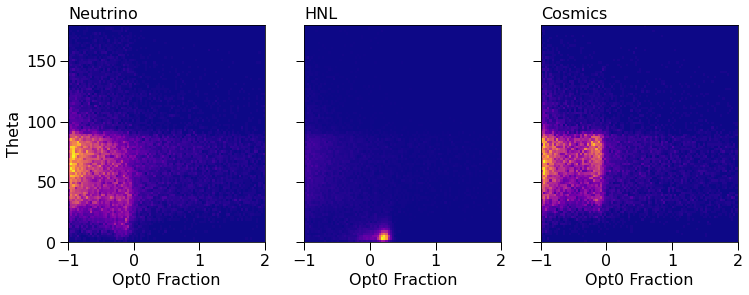

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey= True, sharex = True)

xmin, xmax = -1, 2
xnbin = 90

ymin, ymax = 0, 180
ynbin = 90

xlimmin, xlimmax = xmin, xmax
ylimmin, ylimmax = ymin, ymax
#----------------------------------------------
plot_2dhist( df_nu_shw1['slc_opt0_frac'], df_nu_shw1['slc_pfp_shower_theta'], 
            ax1, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            #weights = df_nu['scale_pot'],
            title = 'Neutrino', xtitle = 'Opt0 Fraction', ytitle= 'Theta'
                )
#----------------------------------------------
plot_2dhist( df_hnl_shw1['slc_opt0_frac'], df_hnl_shw1['slc_pfp_shower_theta'], 
            ax2, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            #weights = df_hnl['scale_pot'],
            title = 'HNL', xtitle = 'Opt0 Fraction', ytitle= ''
                )
#----------------------------------------------
plot_2dhist( df_cos_shw1['slc_opt0_frac'], df_cos_shw1['slc_pfp_shower_theta'], 
            ax3, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            #weights = df_cos['scale_pot'],
            title = 'Cosmics', xtitle = 'Opt0 Fraction', ytitle= ''
                )
#----------------------------------------------
#plt.ylim(0,40)

ax1.tick_params(bottom = True, top = False, left = True, right = False)
ax1.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax1.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax2.tick_params(bottom = True, top = False, left = True, right = False)
ax2.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax2.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax3.tick_params(bottom = True, top = False, left = True, right = False)
ax3.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax3.tick_params(axis = 'y', labelsize = 16, direction = 'out')

plt.show()

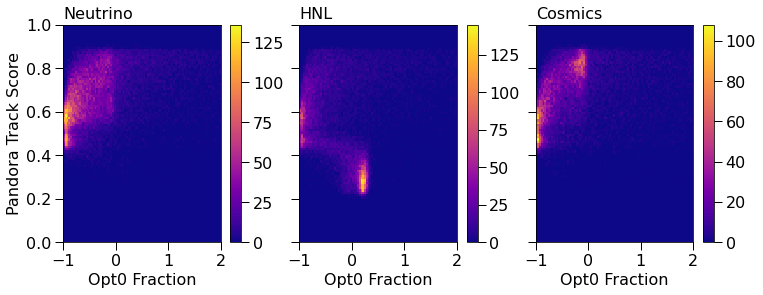

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey= True, sharex = True)

xmin, xmax = -1, 2
xnbin = 90

ymin, ymax = 0, 1
ynbin = 90

xlimmin, xlimmax = xmin, xmax
ylimmin, ylimmax = ymin, ymax
#----------------------------------------------
plot_2dhist( df_nu_shw1['slc_opt0_frac'], df_nu_shw1['slc_pfp_track_score'], 
            ax1, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            #weights = df_nu['scale_pot'],
            title = 'Neutrino', xtitle = 'Opt0 Fraction', ytitle= 'Pandora Track Score'
                )
#----------------------------------------------
plot_2dhist( df_hnl_shw1['slc_opt0_frac'], df_hnl_shw1['slc_pfp_track_score'], 
            ax2, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            #weights = df_hnl['scale_pot'],
            title = 'HNL', xtitle = 'Opt0 Fraction', ytitle= ''
                )
#----------------------------------------------
plot_2dhist( df_cos_shw1['slc_opt0_frac'], df_cos_shw1['slc_pfp_track_score'], 
            ax3, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            #weights = df_cos['scale_pot'],
            title = 'Cosmics', xtitle = 'Opt0 Fraction', ytitle= ''
                )
#----------------------------------------------
#plt.ylim(0,40)

ax1.tick_params(bottom = True, top = False, left = True, right = False)
ax1.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax1.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax2.tick_params(bottom = True, top = False, left = True, right = False)
ax2.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax2.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax3.tick_params(bottom = True, top = False, left = True, right = False)
ax3.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax3.tick_params(axis = 'y', labelsize = 16, direction = 'out')

plt.show()

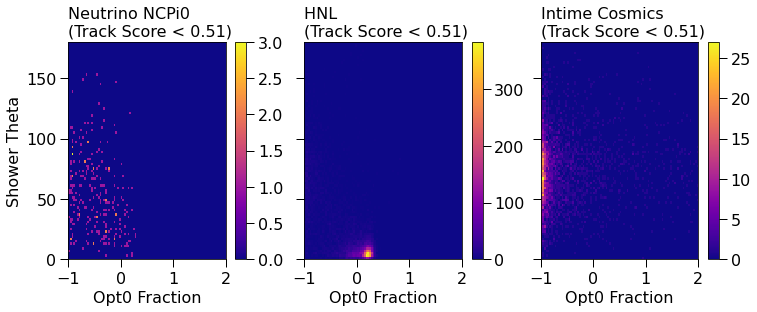

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey= True, sharex = True)

xmin, xmax = -1, 2
xnbin = 90

ymin, ymax = 0, 180
ynbin = 90

xlimmin, xlimmax = xmin, xmax
ylimmin, ylimmax = ymin, ymax
#----------------------------------------------
when = (df_nu_shw1['slc_pfp_track_score'] < 0.51) & (df_nu_shw1['slc_true_event_type'] == 3)

plot_2dhist( df_nu_shw1['slc_opt0_frac'][when], df_nu_shw1['slc_pfp_shower_theta'][when], 
            ax1, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            #weights = df_nu['scale_pot'],
            title = 'Neutrino NCPi0 \n(Track Score < 0.51)', xtitle = 'Opt0 Fraction', ytitle= 'Shower Theta'
                )
#----------------------------------------------
when = df_hnl_shw1['slc_pfp_track_score'] < 0.51

plot_2dhist( df_hnl_shw1['slc_opt0_frac'][when], df_hnl_shw1['slc_pfp_shower_theta'][when], 
            ax2, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            #weights = df_hnl['scale_pot'],
            title = 'HNL \n(Track Score < 0.51)', xtitle = 'Opt0 Fraction', ytitle= ''
                )
#----------------------------------------------
when = df_cos_shw1['slc_pfp_track_score'] < 0.51

plot_2dhist( df_cos_shw1['slc_opt0_frac'][when], df_cos_shw1['slc_pfp_shower_theta'][when], 
            ax3, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            #weights = df_cos['scale_pot'],
            title = 'Intime Cosmics \n(Track Score < 0.51)', xtitle = 'Opt0 Fraction', ytitle= ''
                )
#----------------------------------------------
#plt.ylim(0,40)

ax1.tick_params(bottom = True, top = False, left = True, right = False)
ax1.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax1.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax2.tick_params(bottom = True, top = False, left = True, right = False)
ax2.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax2.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax3.tick_params(bottom = True, top = False, left = True, right = False)
ax3.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax3.tick_params(axis = 'y', labelsize = 16, direction = 'out')

plt.show()

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey= True, sharex = True)

xmin, xmax = -1, 2
xnbin = 90

ymin, ymax = 0, 3000
ynbin = 90

xlimmin, xlimmax = xmin, xmax
ylimmin, ylimmax = ymin, ymax
#----------------------------------------------
when = (df_nu_shw1['slc_pfp_track_score'] > 0.51) #& (df_nu_shw1['slc_true_event_type'] == 3)

plot_2dhist( df_nu_shw1['slc_opt0_frac'][when], df_nu_shw1['slc_pfp_shower_energy'][when], 
            ax1, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            iflog = True, cmin= 1, cmax =200,
            #weights = df_nu['scale_pot'],
            title = 'Neutrino \n(Track Score > 0.51)', xtitle = 'Opt0 Fraction', ytitle= 'Track Energy [MeV]'
                )
#----------------------------------------------
when = df_hnl_shw1['slc_pfp_track_score'] > 0.51

plot_2dhist( df_hnl_shw1['slc_opt0_frac'][when], df_hnl_shw1['slc_pfp_shower_energy'][when], 
            ax2, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            iflog = True, cmin= 1, cmax =200,
            #weights = df_hnl['scale_pot'],
            title = 'HNL \n(Track Score > 0.51)', xtitle = 'Opt0 Fraction', ytitle= ''
                )
#----------------------------------------------
when = df_cos_shw1['slc_pfp_track_score'] > 0.51

plot_2dhist( df_cos_shw1['slc_opt0_frac'][when], df_cos_shw1['slc_pfp_shower_energy'][when], 
            ax3, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            iflog = True, cmin= 1, cmax =200,
            #weights = df_cos['scale_pot'],
            title = 'Intime Cosmics \n(Track Score > 0.51)', xtitle = 'Opt0 Fraction', ytitle= ''
                )
#----------------------------------------------
#plt.ylim(0,40)

ax1.tick_params(bottom = True, top = False, left = True, right = False)
ax1.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax1.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax2.tick_params(bottom = True, top = False, left = True, right = False)
ax2.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax2.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax3.tick_params(bottom = True, top = False, left = True, right = False)
ax3.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax3.tick_params(axis = 'y', labelsize = 16, direction = 'out')
#----------------------------------------------

#----------------------------------------------
fig.tight_layout()
plt.savefig(savePath+"opt0Frac_track_like.png", dpi=200)
plt.show()

NameError: name 'plt' is not defined

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey= True, sharex = True)

xmin, xmax = -1, 2
xnbin = 90

ymin, ymax = 0, 3000
ynbin = 90

xlimmin, xlimmax = xmin, xmax
ylimmin, ylimmax = ymin, ymax
#----------------------------------------------
when = (df_nu_shw1['slc_pfp_track_score'] < 0.51) #& (df_nu_shw1['slc_true_event_type'] == 3)

plot_2dhist( df_nu_shw1['slc_opt0_frac'][when], df_nu_shw1['slc_pfp_shower_energy'][when], 
            ax1, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            iflog = True, cmin= 1, cmax =200,
            #weights = df_nu['scale_pot'],
            title = 'Neutrino \n(Track Score < 0.51)', xtitle = 'Opt0 Fraction', ytitle= 'Shower Energy [MeV]'
                )
#----------------------------------------------
when = df_hnl_shw1['slc_pfp_track_score'] < 0.51

plot_2dhist( df_hnl_shw1['slc_opt0_frac'][when], df_hnl_shw1['slc_pfp_shower_energy'][when], 
            ax2, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            #weights = df_hnl['scale_pot'],
            iflog = True, cmin= 1, cmax =200,
            title = 'HNL \n(Track Score < 0.51)', xtitle = 'Opt0 Fraction', ytitle= ''
                )
#----------------------------------------------
when = df_cos_shw1['slc_pfp_track_score'] < 0.51

plot_2dhist( df_cos_shw1['slc_opt0_frac'][when], df_cos_shw1['slc_pfp_shower_energy'][when], 
            ax3, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            #weights = df_cos['scale_pot'],
            iflog = True, cmin= 1, cmax =200,
            title = 'Intime Cosmics \n(Track Score < 0.51)', xtitle = 'Opt0 Fraction', ytitle= ''
                )
#----------------------------------------------
#plt.ylim(0,40)

ax1.tick_params(bottom = True, top = False, left = True, right = False)
ax1.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax1.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax2.tick_params(bottom = True, top = False, left = True, right = False)
ax2.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax2.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax3.tick_params(bottom = True, top = False, left = True, right = False)
ax3.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax3.tick_params(axis = 'y', labelsize = 16, direction = 'out')


ax1.axhline(y = 300, color = 'r', linestyle = '--') 
ax2.axhline(y = 300, color = 'r', linestyle = '--') 
ax3.axhline(y = 300, color = 'r', linestyle = '--') 


fig.tight_layout()
plt.savefig(savePath+"opt0Frac_shower_like.png", dpi=200)
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey= True, sharex = True)

xmin, xmax = 0, 50000
xnbin = 90

ymin, ymax = 0, 3000
ynbin = 90

xlimmin, xlimmax = xmin, xmax
ylimmin, ylimmax = ymin, ymax
#----------------------------------------------
when = (df_nu_shw1['slc_pfp_track_score'] < 0.51) #& (df_nu_shw1['slc_true_event_type'] == 3)

plot_2dhist( df_nu_shw1['slc_opt0_score'][when], df_nu_shw1['slc_pfp_shower_energy'][when], 
            ax1, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            iflog = True, cmin= 1, cmax =200,
            #weights = df_nu['scale_pot'],
            title = 'Neutrino \n(Track Score < 0.51)', xtitle = 'Opt0 Score', ytitle= 'Shower Energy [MeV]'
                )
#----------------------------------------------
when = df_hnl_shw1['slc_pfp_track_score'] < 0.51

plot_2dhist( df_hnl_shw1['slc_opt0_score'][when], df_hnl_shw1['slc_pfp_shower_energy'][when], 
            ax2, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            #weights = df_hnl['scale_pot'],
            iflog = True, cmin= 1, cmax =200,
            title = 'HNL \n(Track Score < 0.51)', xtitle = 'Opt0 Score', ytitle= ''
                )
#----------------------------------------------
when = df_cos_shw1['slc_pfp_track_score'] < 0.51

plot_2dhist( df_cos_shw1['slc_opt0_score'][when], df_cos_shw1['slc_pfp_shower_energy'][when], 
            ax3, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            #weights = df_cos['scale_pot'],
            iflog = True, cmin= 1, cmax =200,
            title = 'Intime Cosmics \n(Track Score < 0.51)', xtitle = 'Opt0 Score', ytitle= ''
                )
#----------------------------------------------
#plt.ylim(0,40)

ax1.tick_params(bottom = True, top = False, left = True, right = False)
ax1.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax1.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax2.tick_params(bottom = True, top = False, left = True, right = False)
ax2.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax2.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax3.tick_params(bottom = True, top = False, left = True, right = False)
ax3.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax3.tick_params(axis = 'y', labelsize = 16, direction = 'out')


ax1.axhline(y = 300, color = 'r', linestyle = '--') 
ax2.axhline(y = 300, color = 'r', linestyle = '--') 
ax3.axhline(y = 300, color = 'r', linestyle = '--') 


fig.tight_layout()
plt.savefig(savePath+"opt0Score_shower_like.png", dpi=200)
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey= True, sharex = True)

xmin, xmax = -1, 2
xnbin = 90

ymin, ymax = -1000, 50000
ynbin = 90

xlimmin, xlimmax = xmin, xmax
ylimmin, ylimmax = ymin, ymax
#----------------------------------------------
when = (df_nu_shw1['slc_pfp_track_score'] < 0.51) #& (df_nu_shw1['slc_true_event_type'] == 3)

plot_2dhist( df_nu_shw1['slc_opt0_frac'][when], df_nu_shw1['slc_opt0_score'][when], 
            ax1, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            iflog = True, cmin= 1, cmax =200,
            #weights = df_nu['scale_pot'],
            title = 'Neutrino \n(Track Score < 0.51)', xtitle = 'Opt0 Fraction', ytitle= 'Opt0 Score'
                )
#----------------------------------------------
when = df_hnl_shw1['slc_pfp_track_score'] < 0.51

plot_2dhist( df_hnl_shw1['slc_opt0_frac'][when], df_hnl_shw1['slc_opt0_score'][when], 
            ax2, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            iflog = True, cmin= 1, cmax =200,
            #weights = df_hnl['scale_pot'],
            title = 'HNL \n(Track Score < 0.51)', xtitle = 'Opt0 Fraction', ytitle= ''
                )
#----------------------------------------------
when = df_cos_shw1['slc_pfp_track_score'] < 0.51

plot_2dhist( df_cos_shw1['slc_opt0_frac'][when], df_cos_shw1['slc_opt0_score'][when], 
            ax3, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            iflog = True, cmin= 1, cmax =200,
            #weights = df_cos['scale_pot'],
            title = 'Intime Cosmics \n(Track Score < 0.51)', xtitle = 'Opt0 Fraction', ytitle= ''
                )
#----------------------------------------------
#plt.ylim(0,40)

ax1.tick_params(bottom = True, top = False, left = True, right = False)
ax1.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax1.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax2.tick_params(bottom = True, top = False, left = True, right = False)
ax2.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax2.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax3.tick_params(bottom = True, top = False, left = True, right = False)
ax3.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax3.tick_params(axis = 'y', labelsize = 16, direction = 'out')


#ax1.axhline(y = 300, color = 'r', linestyle = '--') 
#ax2.axhline(y = 300, color = 'r', linestyle = '--') 
#ax3.axhline(y = 300, color = 'r', linestyle = '--') 

fig.tight_layout()
plt.savefig(savePath+"opt0Frac_shower_like.png", dpi=200)
plt.show()

In [ ]:
fig, (ax) = plt.subplots(1, 1, figsize=(7, 5), sharey= True, sharex = True)



xmin, xmax, xnbin = 0, 3000, 100
xlimmin, xlimmax = xmin, xmax
#----------------------------------------------
when = df_cos_shw1['slc_pfp_track_score'] > 0.51
pltdf = df_cos_shw1['slc_pfp_track_ke'][when]
plot_1dhist(    pltdf, 
                ax,
                xmin, xmax, xnbin,
                xlimmin, xlimmax,
                ifnorm = True, 
                histtype = 'step', 
                linecolor = col_dict['MintGreen'],
                linewidth = 2,
                label = 'Intime Cosmics (Track Score > 0.51)',
                iflabelbox = True,
           )

#----------------------------------------------
when = df_nu_shw1['slc_pfp_track_score'] > 0.51
pltdf = df_nu_shw1['slc_pfp_track_ke'][when]
plot_1dhist(    pltdf, 
                ax,
                xmin, xmax, xnbin,
                xlimmin, xlimmax,
                ifnorm = True, 
                histtype = 'step', 
                linecolor = col_dict['Teal'],
                linewidth = 2,
                label = 'Neutrino (Track Score > 0.51)',
           )
#----------------------------------------------
when = df_hnl_shw1['slc_pfp_track_score'] > 0.51
pltdf = df_hnl_shw1['slc_pfp_track_ke'][when]
plot_1dhist(    pltdf, 
                ax,
                xmin, xmax, xnbin,
                xlimmin, xlimmax,
                ifnorm = True, 
                xtitle = 'Track Energy [MeV]', ytitle = 'Entries [a.u.]',
                histtype = 'step', 
                linecolor = col_dict['Flamingo'],
                linewidth = 2,
                label = 'HNL (Track Score > 0.51)',
                iflabelbox = True,
           )
#----------------------------------------------
fig.tight_layout()
plt.savefig(savePath+"energy_track_like.png", dpi=200)
plt.show()

In [ ]:
fig, (ax) = plt.subplots(1, 1, figsize=(7, 5), sharey= True, sharex = True)



xmin, xmax, xnbin = 0, 3000, 100
xlimmin, xlimmax = xmin, xmax

#----------------------------------------------
when = df_cos_shw1['slc_pfp_track_score'] < 0.51
pltdf = df_cos_shw1['slc_pfp_shower_energy'][when]
plot_1dhist(    pltdf, 
                ax,
                xmin, xmax, xnbin,
                xlimmin, xlimmax,
                ifnorm = True, 
                histtype = 'step', 
                linecolor = col_dict['MintGreen'],
                linewidth = 2,
                label = 'Intime Cosmics (Track Score < 0.51)',
                iflabelbox = True,
           )

#----------------------------------------------
when = df_nu_shw1['slc_pfp_track_score'] < 0.51
pltdf = df_nu_shw1['slc_pfp_shower_energy'][when]
plot_1dhist(    pltdf, 
                ax,
                xmin, xmax, xnbin,
                xlimmin, xlimmax,
                ifnorm = True, 
                histtype = 'step', 
                linecolor = col_dict['Teal'],
                linewidth = 2,
                label = 'Neutrino (Track Score < 0.51)',
           )
#----------------------------------------------
when = df_hnl_shw1['slc_pfp_track_score'] < 0.51
pltdf = df_hnl_shw1['slc_pfp_shower_energy'][when]
plot_1dhist(    pltdf, 
                ax,
                xmin, xmax, xnbin,
                xlimmin, xlimmax,
                ifnorm = True, 
                xtitle = 'Shower Energy [MeV]', ytitle = 'Entries [a.u.]',
                histtype = 'step', 
                linecolor = col_dict['Flamingo'],
                linewidth = 2,
                label = 'HNL (Track Score < 0.51)',
                iflabelbox = True,
           )
#----------------------------------------------
fig.tight_layout()
plt.savefig(savePath+"energy_shower_like.png", dpi=200)
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey= True, sharex = True)

xmin, xmax = 0,180
xnbin = 90

ymin, ymax = 0, 3000
ynbin = 90

xlimmin, xlimmax = xmin, xmax
ylimmin, ylimmax = ymin, ymax
#----------------------------------------------
when = (df_nu_shw1['slc_pfp_track_score'] < 0.51) #& (df_nu_shw1['slc_true_event_type'] == 3)

plot_2dhist( df_nu_shw1['slc_pfp_shower_theta'][when], df_nu_shw1['slc_pfp_shower_energy'][when], 
            ax1, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            iflog = True, cmin= 1, cmax =200,
            #weights = df_nu['scale_pot'],
            title = 'Neutrino \n(Track Score < 0.51)', xtitle = 'Shower Theta', ytitle= 'Shower Energy [MeV]'
                )
#----------------------------------------------
when = df_hnl_shw1['slc_pfp_track_score'] < 0.51

plot_2dhist( df_hnl_shw1['slc_pfp_shower_theta'][when], df_hnl_shw1['slc_pfp_shower_energy'][when], 
            ax2, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            #weights = df_hnl['scale_pot'],
            iflog = True, cmin= 1, cmax =200,
            title = 'HNL \n(Track Score < 0.51)', xtitle = 'Shower Theta', ytitle= ''
                )
#----------------------------------------------
when = df_cos_shw1['slc_pfp_track_score'] < 0.51

plot_2dhist( df_cos_shw1['slc_pfp_shower_theta'][when], df_cos_shw1['slc_pfp_shower_energy'][when], 
            ax3, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            #weights = df_cos['scale_pot'],
            iflog = True, cmin= 1, cmax =200,
            title = 'Intime Cosmics \n(Track Score < 0.51)', xtitle = 'Shower Theta', ytitle= ''
                )
#----------------------------------------------
#plt.ylim(0,40)

ax1.tick_params(bottom = True, top = False, left = True, right = False)
ax1.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax1.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax2.tick_params(bottom = True, top = False, left = True, right = False)
ax2.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax2.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax3.tick_params(bottom = True, top = False, left = True, right = False)
ax3.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax3.tick_params(axis = 'y', labelsize = 16, direction = 'out')


ax1.axhline(y = 300, color = 'r', linestyle = '--') 
ax2.axhline(y = 300, color = 'r', linestyle = '--') 
ax3.axhline(y = 300, color = 'r', linestyle = '--') 


fig.tight_layout()
#plt.savefig(savePath+"opt0Frac_shower_like.png", dpi=200)
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey= True, sharex = True)

xmin, xmax = -1,2
xnbin = 90

ymin, ymax = 0, 180
ynbin = 90

xlimmin, xlimmax = xmin, xmax
ylimmin, ylimmax = ymin, ymax
#----------------------------------------------
when = (df_nu_shw1['slc_pfp_track_score'] > 0.51) #& (df_nu_shw1['slc_true_event_type'] == 3)

plot_2dhist( df_nu_shw1['slc_opt0_frac'][when], df_nu_shw1['slc_pfp_shower_theta'][when], 
            ax1, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            iflog = True, cmin= 1, cmax =200,
            #weights = df_nu['scale_pot'],
            title = 'Neutrino \n(Track Score < 0.51)', xtitle = 'Opt0 Fraction', ytitle= 'Shower Theta'
                )
#----------------------------------------------
when = df_hnl_shw1['slc_pfp_track_score'] > 0.51

plot_2dhist( df_hnl_shw1['slc_opt0_frac'][when], df_hnl_shw1['slc_pfp_shower_theta'][when], 
            ax2, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            #weights = df_hnl['scale_pot'],
            iflog = True, cmin= 1, cmax =200,
            title = 'HNL \n(Track Score < 0.51)', xtitle = 'Opt0 Fraction', ytitle= ''
                )
#----------------------------------------------
when = df_cos_shw1['slc_pfp_track_score'] > 0.51

plot_2dhist( df_cos_shw1['slc_opt0_frac'][when], df_cos_shw1['slc_pfp_shower_theta'][when], 
            ax3, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            #weights = df_cos['scale_pot'],
            iflog = True, cmin= 1, cmax =200,
            title = 'Intime Cosmics \n(Track Score < 0.51)', xtitle = 'Opt0 Fraction', ytitle= ''
                )
#----------------------------------------------
#plt.ylim(0,40)

ax1.tick_params(bottom = True, top = False, left = True, right = False)
ax1.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax1.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax2.tick_params(bottom = True, top = False, left = True, right = False)
ax2.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax2.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax3.tick_params(bottom = True, top = False, left = True, right = False)
ax3.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax3.tick_params(axis = 'y', labelsize = 16, direction = 'out')


ax1.axhline(y = 300, color = 'r', linestyle = '--') 
ax2.axhline(y = 300, color = 'r', linestyle = '--') 
ax3.axhline(y = 300, color = 'r', linestyle = '--') 


fig.tight_layout()
#plt.savefig(savePath+"opt0Score_shower_like.png", dpi=200)
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey= True, sharex = True)

xmin, xmax = -1,2
xnbin = 90

ymin, ymax = 0, 180
ynbin = 90

xlimmin, xlimmax = xmin, xmax
ylimmin, ylimmax = ymin, ymax
#----------------------------------------------
when = (df_nu_shw1['slc_pfp_track_score'] < 0.51) #& (df_nu_shw1['slc_true_event_type'] == 3)

plot_2dhist( df_nu_shw1['slc_opt0_frac'][when], df_nu_shw1['slc_pfp_shower_theta'][when], 
            ax1, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            iflog = True, cmin= 1, cmax =200,
            #weights = df_nu['scale_pot'],
            title = 'Neutrino \n(Track Score < 0.51)', xtitle = 'Opt0 Fraction', ytitle= 'Shower Theta'
                )
#----------------------------------------------
when = df_hnl_shw1['slc_pfp_track_score'] < 0.51

plot_2dhist( df_hnl_shw1['slc_opt0_frac'][when], df_hnl_shw1['slc_pfp_shower_theta'][when], 
            ax2, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            #weights = df_hnl['scale_pot'],
            iflog = True, cmin= 1, cmax =200,
            title = 'HNL \n(Track Score < 0.51)', xtitle = 'Opt0 Fraction', ytitle= ''
                )
#----------------------------------------------
when = df_cos_shw1['slc_pfp_track_score'] < 0.51

plot_2dhist( df_cos_shw1['slc_opt0_frac'][when], df_cos_shw1['slc_pfp_shower_theta'][when], 
            ax3, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            #weights = df_cos['scale_pot'],
            iflog = True, cmin= 1, cmax =200,
            title = 'Intime Cosmics \n(Track Score < 0.51)', xtitle = 'Opt0 Fraction', ytitle= ''
                )
#----------------------------------------------
#plt.ylim(0,40)

ax1.tick_params(bottom = True, top = False, left = True, right = False)
ax1.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax1.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax2.tick_params(bottom = True, top = False, left = True, right = False)
ax2.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax2.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax3.tick_params(bottom = True, top = False, left = True, right = False)
ax3.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax3.tick_params(axis = 'y', labelsize = 16, direction = 'out')

#----------------------------------------------
# Creating vectors X and Y
x = np.linspace(-1, 2, 100)
y = ( x + 1 ) * 50
 
# Create the plot
ax2.plot(x, y, color='r')
#----------------------------------------------
#plt.savefig(savePath+"opt0Score_shower_like.png", dpi=200)
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey= True, sharex = True)

xmin, xmax = -1,2
xnbin = 90

ymin, ymax = 0, 180
ynbin = 90

xlimmin, xlimmax = xmin, xmax
ylimmin, ylimmax = ymin, ymax
#----------------------------------------------
plot_2dhist( df_nu_shw1['slc_opt0_frac'], df_nu_shw1['slc_pfp_shower_theta'], 
            ax1, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            iflog = True, cmin= 1, cmax =200,
            #weights = df_nu['scale_pot'],
            title = 'Neutrino \n(Track Score < 0.51)', xtitle = 'Opt0 Fraction', ytitle= 'Shower Theta'
                )
#----------------------------------------------

plot_2dhist( df_hnl_shw1['slc_opt0_frac'], df_hnl_shw1['slc_pfp_shower_theta'], 
            ax2, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            #weights = df_hnl['scale_pot'],
            iflog = True, cmin= 1, cmax =200,
            title = 'HNL \n(Track Score < 0.51)', xtitle = 'Opt0 Fraction', ytitle= ''
                )
#----------------------------------------------

plot_2dhist( df_cos_shw1['slc_opt0_frac'], df_cos_shw1['slc_pfp_shower_theta'], 
            ax3, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            #weights = df_cos['scale_pot'],
            iflog = True, cmin= 1, cmax =200,
            title = 'Intime Cosmics \n(Track Score < 0.51)', xtitle = 'Opt0 Fraction', ytitle= ''
                )
#----------------------------------------------
#plt.ylim(0,40)

ax1.tick_params(bottom = True, top = False, left = True, right = False)
ax1.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax1.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax2.tick_params(bottom = True, top = False, left = True, right = False)
ax2.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax2.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax3.tick_params(bottom = True, top = False, left = True, right = False)
ax3.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax3.tick_params(axis = 'y', labelsize = 16, direction = 'out')

#----------------------------------------------
# Creating vectors X and Y
x = np.linspace(-1, 2, 100)
y = ( x + 1 ) * 20 - 20
 
# Create the plot
ax2.plot(x, y, color='r')
#----------------------------------------------
#plt.savefig(savePath+"opt0Score_shower_like.png", dpi=200)
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey= True, sharex = True)

xmin, xmax = -1,2
xnbin = 90

ymin, ymax = 0, 3000
ynbin = 90

xlimmin, xlimmax = xmin, xmax
ylimmin, ylimmax = ymin, ymax
#----------------------------------------------
when = (df_nu_shw1['slc_pfp_track_score'] < 0.51) #& (df_nu_shw1['slc_true_event_type'] == 3)

plot_2dhist( df_nu_shw1['slc_opt0_frac'][when], df_nu_shw1['slc_pfp_shower_energy'][when], 
            ax1, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            iflog = True, cmin= 1, cmax =200,
            #weights = df_nu['scale_pot'],
            title = 'Neutrino \n(Track Score < 0.51)', xtitle = 'Shower Energy [MeV]', ytitle= 'Shower Theta'
                )
#----------------------------------------------
when = df_hnl_shw1['slc_pfp_track_score'] < 0.51

plot_2dhist( df_hnl_shw1['slc_opt0_frac'][when], df_hnl_shw1['slc_pfp_shower_energy'][when], 
            ax2, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            #weights = df_hnl['scale_pot'],
            iflog = True, cmin= 1, cmax =200,
            title = 'HNL \n(Track Score < 0.51)', xtitle = 'Shower Energy [MeV]', ytitle= ''
                )
#----------------------------------------------
when = df_cos_shw1['slc_pfp_track_score'] < 0.51

plot_2dhist( df_cos_shw1['slc_opt0_frac'][when], df_cos_shw1['slc_pfp_shower_energy'][when], 
            ax3, fig, 
            xmin, xmax, ymin, ymax, xnbin, ynbin,
            xlimmin, xlimmax, ylimmin, ylimmax,
            ifcbar =True,
            #weights = df_cos['scale_pot'],
            iflog = True, cmin= 1, cmax =200,
            title = 'Intime Cosmics \n(Track Score < 0.51)', xtitle = 'Shower Energy [MeV]', ytitle= ''
                )
#----------------------------------------------
#plt.ylim(0,40)

ax1.tick_params(bottom = True, top = False, left = True, right = False)
ax1.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax1.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax2.tick_params(bottom = True, top = False, left = True, right = False)
ax2.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax2.tick_params(axis = 'y', labelsize = 16, direction = 'out')

ax3.tick_params(bottom = True, top = False, left = True, right = False)
ax3.tick_params(axis = 'x', labelsize = 16, direction = 'out')
ax3.tick_params(axis = 'y', labelsize = 16, direction = 'out')

#----------------------------------------------
# Creating vectors X and Y
x = np.linspace(-1, 2, 100)
y = ( 10 - x ) * 20
 
# Create the plot
ax2.plot(x, y, color='r')
#----------------------------------------------
#plt.savefig(savePath+"opt0Score_shower_like.png", dpi=200)
plt.show()